## Libraries

In [ ]:
import os
import ast
import pandas as pd
import numpy as np
import glob
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Loading Data


In [ ]:
import sys
import os

sys.path.insert(0, '../../')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from library.notebook_api.data_loader import CombinedDataLoader, ModelDataLoader

alt.data_transformers.enable("vegafusion")
alt.renderers.enable('default')

Mounted at /content/drive


In [ ]:
# Initialize ModelDataLoader with the correct directory path
model_data_loader = ModelDataLoader(version='005')

# Access the loaded DataFrame
df = model_data_loader.df
print("DataFrame loaded:")
display(df.head())

DataFrame loaded:


,track_id,dataset,audio_path,label,fma_genre_top,fma_genres,fma_genres_all,file_available,sampling_rate,features,...,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
0,000002,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,"[3683.9976, 1.2325847, -0.45687142, 3495.6704,...",...,0.098364,0.141225,0.424169,-1.742610,1.403928,166.708664,21.300203,0.022087,-505.499176,196.868652
1,000005,fma,/project_data_source/free_music_archive/fma_sm...,hiphop,Hip-Hop,[21],[21],1.0,44100,"[2928.3987, 0.68091094, 0.02261393, 3383.929, ...",...,0.059334,0.145243,0.475249,1.318397,1.384270,99.384018,21.096722,0.005648,-528.116272,209.443054
2,000010,fma,/project_data_source/free_music_archive/fma_sm...,pop,Pop,[10],[10],1.0,44100,"[2786.7935, -0.85456085, -0.076387875, 2895.75...",...,0.080989,0.186656,0.430406,2.244156,1.123551,112.347145,20.852177,-0.033316,-537.197205,229.155151
3,000140,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,"[1957.3483, 1.3831364, 0.35159802, 2927.9644, ...",...,0.027256,0.068459,0.450882,-3.624865,1.135973,107.666016,21.727451,0.012266,-592.895813,199.950806
4,000141,fma,/project_data_source/free_music_archive/fma_sm...,folk,Folk,[17],[17],1.0,44100,"[1768.6066, 1.1223011, -0.09913131, 2358.3088,...",...,0.034120,0.100852,0.341356,-4.471582,0.881413,120.185318,23.654802,-0.003315,-536.546936,222.208649


In [ ]:
# Specify the genres to filter
selected_genres = ['rock', 'electronic', 'hiphop', 'classical', 'jazz', 'country']

# Filter the DataFrame
df = df[df['label'].isin(selected_genres)]

## Elbow Curve

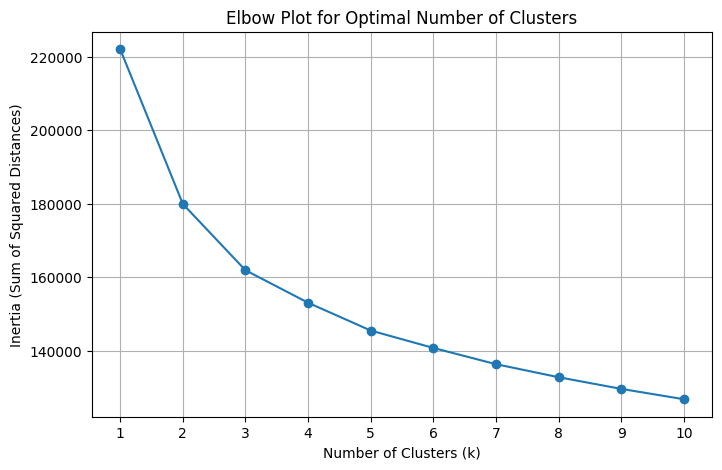

In [ ]:
# Extract features and target
X = df[model_data_loader.feature_names].dropna()  # Features
y = df['label']  # Target labels

# Step 1: Preprocessing - Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Elbow Method for Optimal Clusters
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(cluster_range)
plt.grid()
plt.show()

## PCA and K Means Clustering

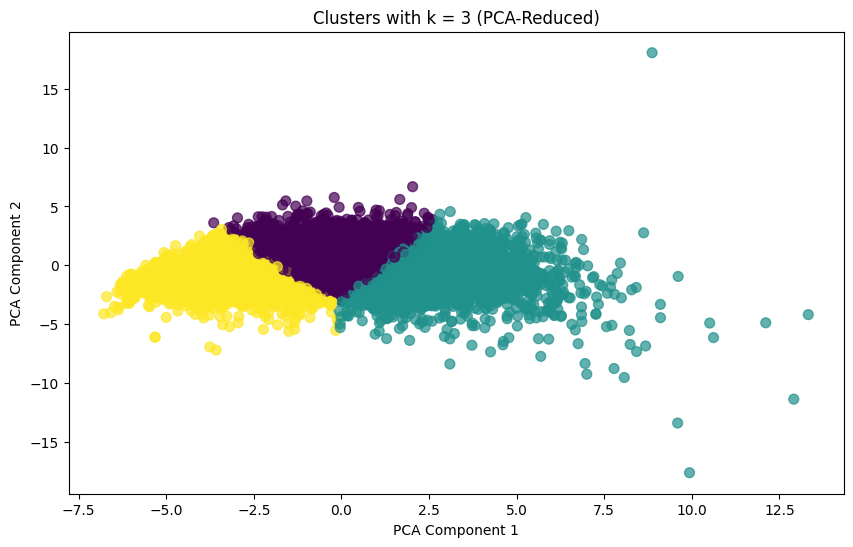

In [ ]:
# Perform K-means clustering with the optimal number of clusters
optimal_clusters = 3  # Based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the clusters without centroids
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters with k = 3 (PCA-Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Add the cluster labels to the original DataFrame
df['Cluster'] = None
df.loc[X.index, 'Cluster'] = labels

In [ ]:
# Evaluate clustering
silhouette_avg = silhouette_score(X_scaled, labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
davies_bouldin = davies_bouldin_score(X_scaled, labels)

# Print evaluation metrics
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Silhouette Score: 0.1531
Calinski-Harabasz Index: 2748.9741
Davies-Bouldin Index: 1.9669


In [ ]:
# Split the features array into separate columns
for index, feature_name in enumerate(model_data_loader.feature_names):
    df[feature_name] = df.features.map(lambda x: x[index] if x is not None else None)

# Group by cluster and calculate the mean for each feature
cluster_feature_averages = df.groupby('Cluster')[model_data_loader.feature_names].mean()

# Display the results
print("Average of each feature for each cluster:")
display(cluster_feature_averages)

Average of each feature for each cluster:


,spectral_centroids_mean,spectral_centroids_delta_mean,spectral_centroids_accelerate_mean,spectral_bandwidth_mean,spectral_rolloff_mean,zero_crossing_rate_mean,rms_mean,chroma_stft_mean,mfccs_mean,onset,tempo,contrast,tonnetz,mfccs_min,mfccs_max
Cluster,,,,,,,,,,,,,,,
0,2277.970207,0.086214,0.023301,2791.544628,4623.624531,0.048985,0.187283,0.501289,3.479683,1.152549,123.927664,20.522189,0.008991,-487.836410,224.972174
1,3828.287992,0.144861,-0.083116,4083.929206,8169.164548,0.081381,0.210895,0.521339,4.179962,1.288537,122.808480,20.204693,0.006850,-472.592507,188.910666
2,1413.870709,0.074096,0.062209,1867.174791,2555.873177,0.036214,0.088064,0.372707,-10.009250,0.894406,123.522092,22.521776,0.010077,-576.321571,242.771967


## Cluster Characteristics with Emotional Descriptions

### Cluster 0:
**Characteristics:**
- Spectral Centroids Mean: Moderate (2277.97) - indicative of balanced brightness.
- Spectral Bandwidth Mean: Moderate (2791.54) - suggesting medium harmonic complexity.
- Zero Crossing Rate Mean: Moderate (0.0489) - balanced sharpness in sounds.
- MFCCs Mean: Moderate (3.48) - suggesting a balanced tonal texture.
- MFCCs Min: Lower (-487.84) - indicative of deeper or darker tones.
- MFCCs Max: Moderate (224.97) - reflecting a range of tonal variation.
- Tempo: ~123.93 BPM - slightly faster-paced tracks.
- Contrast: Moderate (20.52) - indicating medium dynamics in the audio.

**Emotional Description:**
Bright, energetic, and balanced. Suitable for uplifting or motivating moods.

**Genres in Cluster 0:**
Rock, Electronic, Hiphop.

---

### Cluster 1:
**Characteristics:**
- Spectral Centroids Mean: Higher (3828.29) - indicative of brighter sounds.
- Spectral Bandwidth Mean: Higher (4083.93) - suggesting complex harmonic content.
- Zero Crossing Rate Mean: Higher (0.0814) - likely sharper, more percussive sounds.
- MFCCs Mean: Slightly Higher (4.18) - suggesting richer tonal qualities.
- MFCCs Min: Lower (-472.59) - indicative of darker tones.
- MFCCs Max: Moderate (188.91) - suggesting a controlled range of tonal variation.
- Tempo: ~122.81 BPM - slightly slower-paced tracks.
- Contrast: Moderate (20.20) - indicating medium dynamics.

**Emotional Description:**
Warm, dynamic, and engaging. Evokes a calm yet inspiring mood.

**Genres in Cluster 1:**
Jazz, Classical.

---

### Cluster 2:
**Characteristics:**
- Spectral Centroids Mean: Lowest (1413.87) - indicative of darker, deeper sounds.
- Spectral Bandwidth Mean: Lowest (1867.17) - suggesting simpler harmonic content.
- Zero Crossing Rate Mean: Lowest (0.0362) - smoother sounds with fewer rapid changes.
- MFCCs Mean: Lowest (-10.01) - darker tonal texture.
- MFCCs Min: Lowest (-576.32) - indicative of the deepest and darkest tones.
- MFCCs Max: Highest (242.77) - reflecting a wide tonal range.
- Tempo: ~123.52 BPM - slightly faster-paced tracks.
- Contrast: Highest (22.52) - suggesting high dynamics and variability in the audio.

**Emotional Description:**
Dark, introspective, and emotional. Perfect for reflective or melancholic moods.

**Genres in Cluster 2:**
Country, Classical, Electronic.


## Explanation: How Music Genres Influence Each Other and Impact Classification

### 1. The Fluid Nature of Music Genres
- Music genres are not fixed entities but rather evolving styles that adapt and incorporate elements from other genres over time. This cross-pollination blurs the boundaries between genres and makes classification challenging.
- For example:
  - **Rock and Country**: Many rock songs incorporate storytelling elements, slide guitars, or vocal twangs typical of country music.
  - **Electronic and Jazz**: Electronic artists often draw inspiration from jazz improvisation and harmonic complexity, leading to subgenres like "nu-jazz."

---

### 2. Genre Evolution and Hybridization
- Over time, artists experiment with blending multiple genres, creating hybrid subgenres. This evolution reflects broader cultural, technological, and musical influences:
  - **Hip-Hop and Jazz**: Hip-hop producers often sample jazz melodies, leading to "jazz rap" styles.
  - **Electronic and Classical**: Composers integrate electronic soundscapes into classical compositions, as seen in modern film scores or ambient music.
  - **Country and Pop**: Modern country music increasingly adopts pop production techniques, including synthesized beats and layered vocals.

---

### 3. Cultural and Historical Influence
- Music genres are shaped by cultural movements and historical contexts, which influence their sound:
  - **Jazz**: Originating from African American communities, jazz influenced rock, R&B, and even electronic music.
  - **Electronic Music**: Originally inspired by classical minimalism and experimental techniques, electronic music now spans a spectrum from dance-oriented beats to cinematic ambience.
  - **Classical**: Classical music provides a foundation for many genres by influencing chord progressions, melodies, and structural elements.

---

### 4. Technological Innovations
- Advances in music production and technology allow genres to borrow sounds and techniques from each other, accelerating their convergence:
  - **Sampling and Remixing**: Technologies like sampling allow artists to directly integrate elements of one genre into another (e.g., hip-hop producers sampling funk or soul).
  - **Synthesizers and Drum Machines**: Tools originally associated with electronic music are now staples in pop, rock, and even country music.

---

### 5. The Challenge for Clustering Models
- The overlap and interdependence of genres create complexities for models based solely on numerical audio features:
  - **Shared Features**: Genres with vastly different cultural contexts (e.g., jazz and electronic) may share similar audio features like tempo, MFCC values, or harmonic richness.
  - **Contextual Ambiguity**: A song might have electronic beats but a melodic structure reminiscent of classical music, making it difficult for the model to place it in a single cluster.
  - **Dynamic Evolution**: Genre boundaries shift faster than static models can adapt, leading to misclassification or overlapping clusters.

---

## Broader Implications for Music Analysis
The interconnected nature of music highlights how art forms are inspired by one another. While clustering models reveal useful patterns, they are limited by their inability to capture the cultural and historical nuances that define genres. Future advancements could involve incorporating metadata, lyrics, or artist influences to better contextualize these overlaps and improve classification accuracy.

